In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import torch
from transformers import BertTokenizer, BertModel

**GloVe Word Embeddings**

In [3]:
import gensim.downloader as api
word_vectors = api.load('glove-wiki-gigaword-100')

In [ ]:
import gensim.downloader as api
word_vectors = api.load('word2vec-google-news-300')

In [4]:
word_vectors['king'].shape

(100,)

In [5]:
word_vectors['king'][:20]

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 ], dtype=float32)

In [6]:
# Words to visualize
words = ["king", "princess", "monarch", "throne", "crown",
         "mountain", "ocean", "tv", "rainbow", "cloud", "queen"]

# Get word vectors
vectors = np.array([word_vectors[word] for word in words])

In [7]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

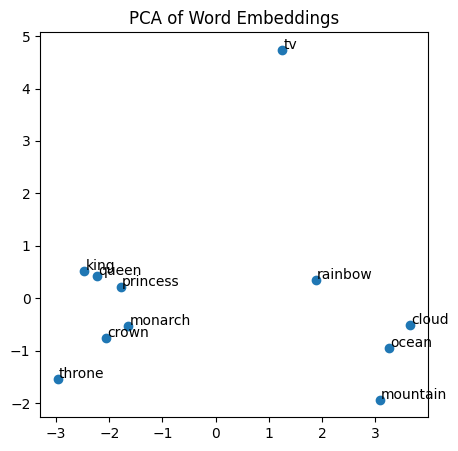

In [8]:
# Plotting
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(vectors_pca[:, 0], vectors_pca[:, 1])
for i, word in enumerate(words):
    axes.annotate(word, (vectors_pca[i, 0]+.02, vectors_pca[i, 1]+.02))
axes.set_title('PCA of Word Embeddings')
plt.show()

**Word2Vec Algebra**

In [9]:
result = word_vectors.most_similar(positive=['king', 'woman'],
                                   negative=['man'], topn=1)

# Output the result
print(f"""
    The word closest to 'king' - 'man' + 'woman' is: '{result[0][0]}'
    with a similarity score of {result[0][1]}""")


    The word closest to 'king' - 'man' + 'woman' is: 'queen' 
    with a similarity score of 0.7698540687561035


In [10]:
result = word_vectors.most_similar(positive=['Paris', 'Spain'],
                                   negative=['France'], topn=1)

# Output the result
print(f"""
    The word closest to 'Paris' - 'France' + 'Spain' is: '{result[0][0]}'
    with a similarity score of {result[0][1]}""")

KeyError: "Key 'Paris' not present in vocabulary"

In [11]:
# Check if the words are in the vocabulary
print("'Paris' in vocabulary:", 'Paris' in word_vectors)
print("'Spain' in vocabulary:", 'Spain' in word_vectors)
print("'France' in vocabulary:", 'France' in word_vectors)

# If any of the words are not in the vocabulary, you will need to either:
# 1. Use a different word that is in the vocabulary
# 2. Retrain your word embeddings model with a corpus that includes the missing words

'Paris' in vocabulary: False
'Spain' in vocabulary: False
'France' in vocabulary: False


**GloVe vs BERT: Words in Context**

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embeddings(sentence, word):
    inputs = tokenizer(sentence, return_tensors='pt')
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    word_tokens = tokenizer.tokenize(sentence)
    word_index = word_tokens.index(word)
    word_embedding = last_hidden_states[0, word_index + 1, :]  # +1 to account for [CLS] token
    return word_embedding

In [13]:
sentence = "The king is sitting on the throne."
word = "king"
embedding = get_bert_embeddings(sentence, word)
print(embedding)

tensor([ 1.0745e-01, -4.8916e-02,  3.4856e-01, -5.5628e-02,  1.5455e-01,
        -9.5148e-01, -2.8183e-01,  5.2890e-01, -3.5254e-01, -7.0603e-01,
         4.2952e-02, -1.9295e-01, -1.4571e-02,  1.9740e-02,  2.3465e-01,
        -7.3879e-02, -2.5985e-01, -1.7765e-01,  2.5749e-01,  5.6928e-01,
        -8.3714e-01,  1.1860e-01,  5.6556e-02,  2.8272e-01,  2.2099e-01,
         3.7261e-01,  3.1754e-01,  9.8186e-01,  1.3532e-01,  4.4859e-01,
         7.1985e-01, -1.3824e-01,  1.4005e-01, -2.3764e-02, -7.9947e-02,
        -3.2679e-01,  8.0708e-01,  2.1175e-01, -8.7354e-01, -3.1936e-02,
        -7.0000e-01, -9.8577e-01,  4.8080e-01,  2.2261e-01, -2.7166e-01,
        -8.5299e-01,  5.5627e-02,  2.5537e-01,  1.2071e+00,  2.3642e-01,
        -3.6511e-01,  3.1798e-01, -1.0120e+00, -5.8978e-01,  8.0578e-01,
         3.9963e-01, -5.6940e-01,  6.5924e-03, -1.3129e-01,  1.3096e-03,
        -6.1496e-02,  7.9447e-02, -1.3878e-01, -7.2424e-01,  2.1856e-01,
         4.0179e-01, -8.4015e-02,  9.0721e-02, -5.1

In [14]:
print(embedding.shape)

torch.Size([768])


In [15]:
sentence1 = "The bat flew out of the cave at night."
sentence2 = "He swung the bat and hit a home run."

word = "bat"

bert_embedding1 = get_bert_embeddings(sentence1, word).detach().numpy()
bert_embedding2 = get_bert_embeddings(sentence2, word).detach().numpy()
word_embedding = word_vectors[word]

In [16]:
print("BERT Embedding for 'bat' in sentence 1:", bert_embedding1[:5])
print("BERT Embedding for 'bat' in sentence 2:", bert_embedding2[:5])
print("GloVe Embedding for 'bat':", word_embedding[:5])

bert_similarity = cosine_similarity([bert_embedding1], [bert_embedding2])[0][0]
word_embedding_similarity = cosine_similarity([word_embedding], [word_embedding])[0][0]

print()
print(f"Cosine Similarity between BERT embeddings in different contexts: {bert_similarity}")
print(f"Cosine Similarity between GloVe embeddings: {word_embedding_similarity}")


BERT Embedding for 'bat' in sentence 1: [ 0.4131613  -0.12908208 -0.44865727 -0.40492675 -0.15305734]
BERT Embedding for 'bat' in sentence 2: [ 0.64066994 -0.31121498 -0.44089845 -0.16551109 -0.2005611 ]
GloVe Embedding for 'bat': [-0.47601  0.81705  0.11151 -0.22687 -0.80672]

Cosine Similarity between BERT embeddings in different contexts: 0.459957480430603
Cosine Similarity between GloVe embeddings: 1.0


**Cross Encoder**

In [17]:
!pip install -U sentence-transformers

In [18]:
from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512,
                     default_activation_function=torch.nn.Sigmoid())

In [19]:
question = "Where is the capital of France?"
# Define sentences to compare
answers = [
    "Paris is the capital of France.",
    "Berlin is the capital of Germany.",
    "Madrid is the capital of Spain."
]

In [20]:
scores = model.predict([(question, answers[0]), (question, answers[1]),
                        (question, answers[2])])
print(scores)
most_relevant_idx = torch.argmax(torch.tensor(scores)).item()
print(f"The most relevant passage is: {answers[most_relevant_idx]}")

[0.99965715 0.0528962  0.04520684]
The most relevant passage is: Paris is the capital of France.
